### **Introduction**

In [67]:
import torch
import wfdb
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import pandas as pd
import scipy as sp

### **Database selection stage**

In [50]:
def plot_signal_lead(record: wfdb.io.record.Record, lead_name: str = "I"):
    lead_index = record.sig_name.index(lead_name)

    plt.figsize=(15, 10)
    plt.plot(record.p_signal[:, lead_index])
    plt.title(f"Lead {lead_name}")
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

#### **PTB-XL Dataset**

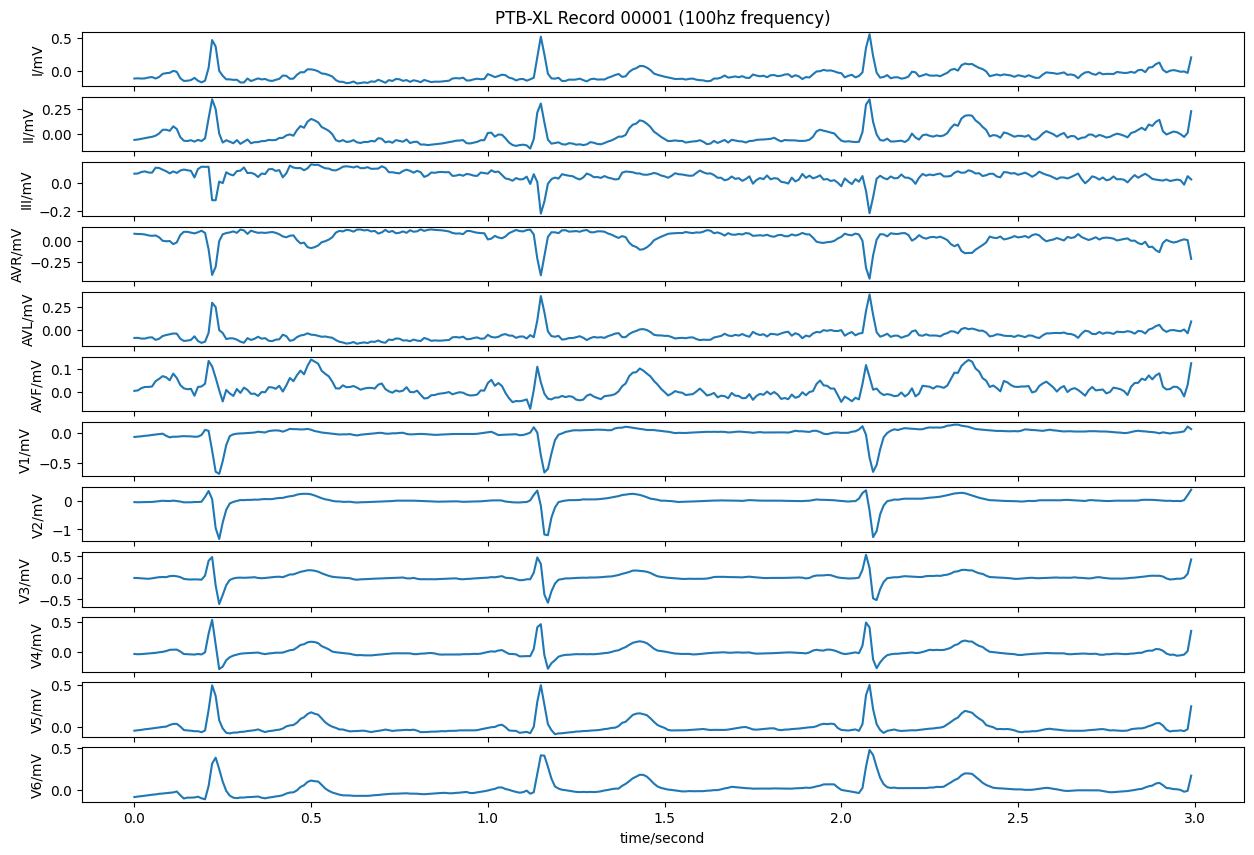

In [51]:
patient_path = "datasets/physionet.org/files/ptb-xl/1.0.3/records100/00000/00001_lr"
patient_record = wfdb.rdrecord(patient_path, sampto=300)
wfdb.plot_wfdb(patient_record, figsize=(15, 10), title='PTB-XL Record 00001 (100hz frequency)', time_units='seconds')

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


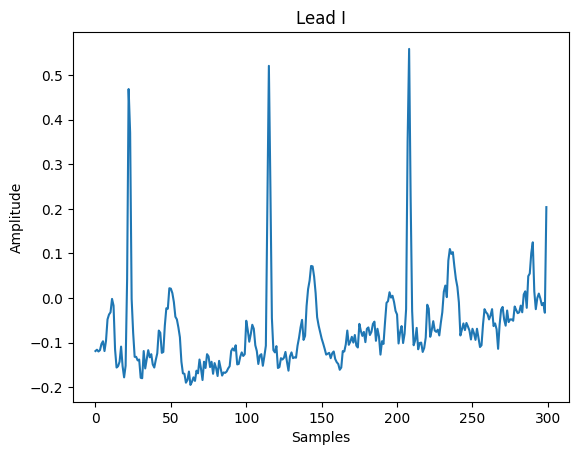

In [52]:
print(f"Leads available: {patient_record.sig_name}")
plot_signal_lead(record=patient_record, lead_name="I")

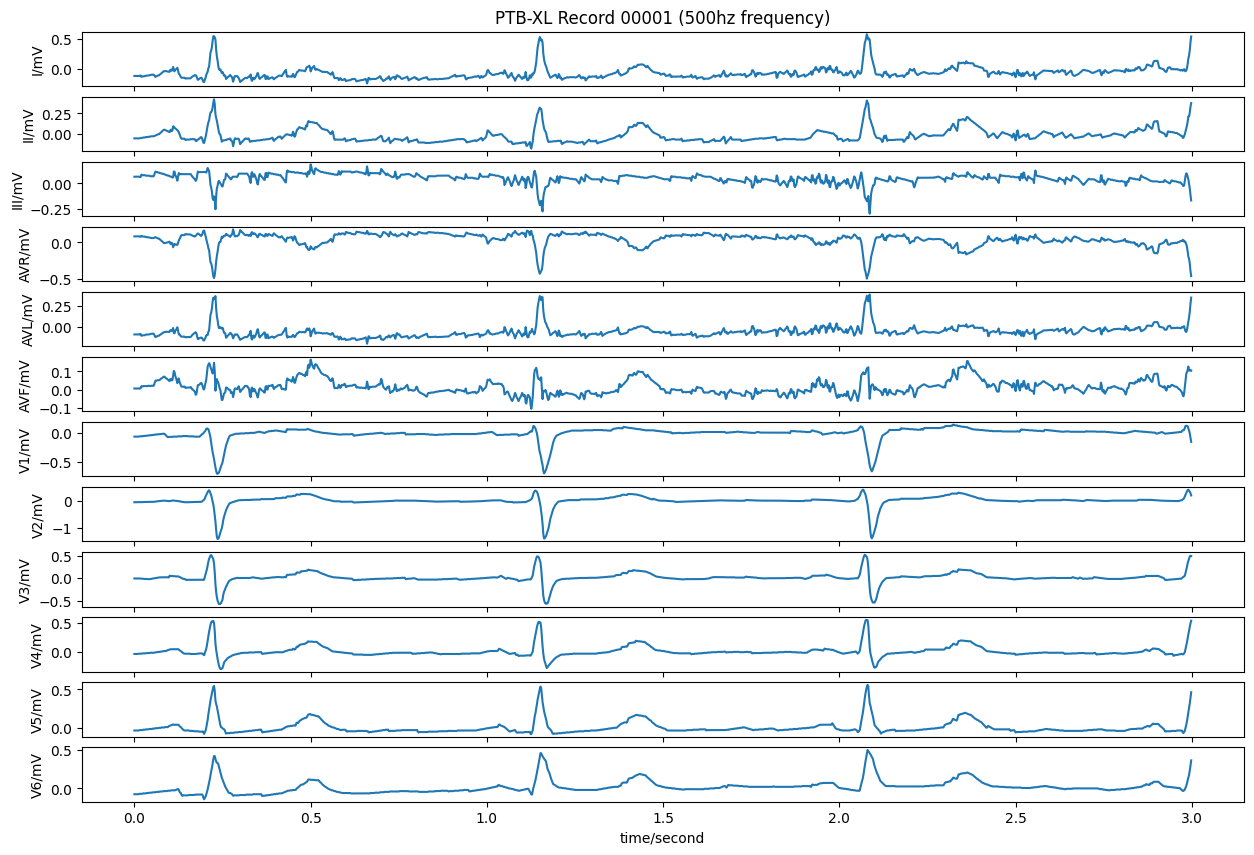

In [53]:
patient_path = "datasets/physionet.org/files/ptb-xl/1.0.3/records500/00000/00001_hr"
patient_record = wfdb.rdrecord(patient_path, sampto=1500)
wfdb.plot_wfdb(patient_record, figsize=(15, 10), title='PTB-XL Record 00001 (500hz frequency)', time_units='seconds')

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


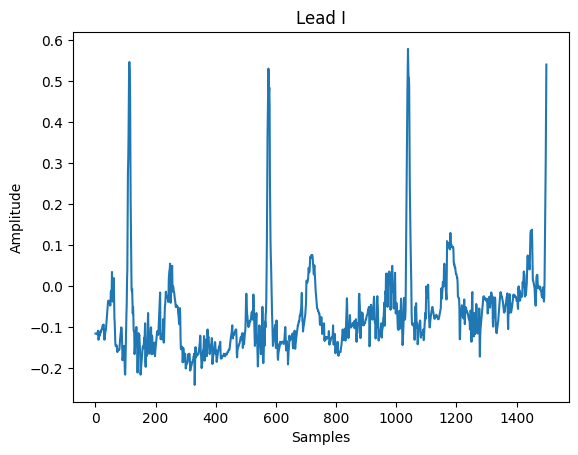

In [54]:
print(f"Leads available: {patient_record.sig_name}")
plot_signal_lead(record=patient_record, lead_name="I")

#### **SaMi-Trop Dataset**

len chagas_label: 815
247007
[2]
Keys available: ['tracings']
(1631, 4096, 12)
(4096, 12)


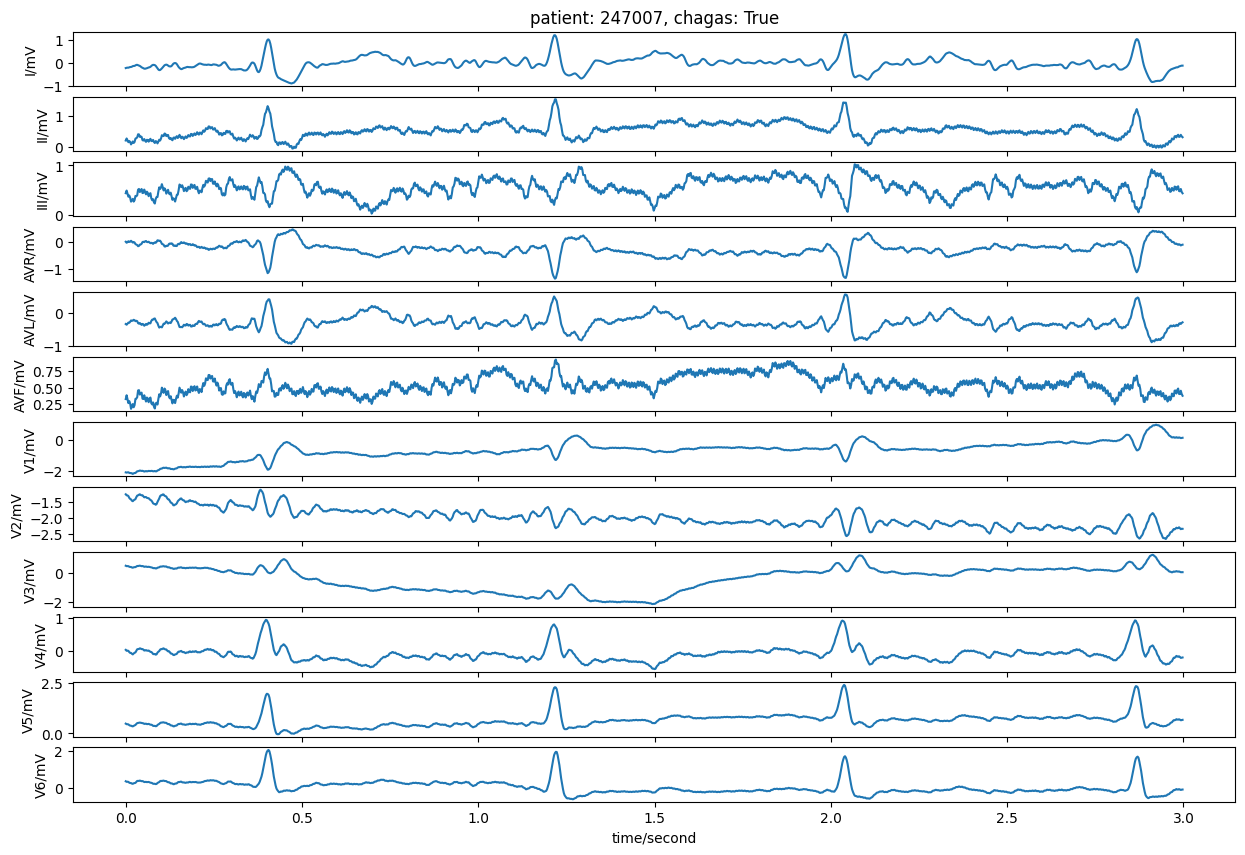

In [59]:
# Path file SaMi-Trop dataset and labels
hdf5_file = "datasets/Sami-Trop/exams.hdf5"
hdf5_labels = "datasets/Sami-Trop/samitrop_chagas_labels.csv"

# Temporary name for WFDB file
temp_dir = tempfile.mkdtemp()
record_name = "test_record"

# Signal parameters
sampling_frequency = 400  # In Hz
lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
units = "mV"
gain = 1000
num_bits = 16

df_labels = pd.read_csv(hdf5_labels)
exam_id = df_labels.iloc[0, 0]
chagas = df_labels.iloc[0, 1] 
print(f"len chagas_label: {len(df_labels)}")
print(exam_id)

df_data = pd.read_csv("datasets/Sami-Trop/exams.csv")
idx = df_data.index[df_data['exam_id'] == exam_id].tolist()
print(idx)

# Reads the first signal from the HDF5 file
with h5py.File(hdf5_file, "r") as f:
    print("Keys available:", list(f.keys()))
    print(f['tracings'].shape)
    physical_signals = np.squeeze(np.array(f['tracings'][idx], dtype=np.float32))  # Primo paziente
    print(physical_signals.shape)
    num_samples, num_leads = physical_signals.shape
    assert num_leads == 12

# Convert signal to digital format for WFDB
digital_signals = np.round(physical_signals * gain).astype(np.int16)
digital_signals = np.clip(digital_signals, -2**(num_bits-1)+1, 2**(num_bits-1)-1)

# Save in WFDB format
wfdb.wrsamp(
    record_name=record_name,
    fs=400,  # Sampling rate
    units=['mV'] * 12,  # Unit of measurement for each derivation
    sig_name=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],  # Derivative names
    d_signal=digital_signals,  # Digital signal
    fmt=['16'] * 12,  # 16-bit format for each derivation
    adc_gain=[1000] * 12,  # Gain for each derivation
    baseline=[0] * 12  # Baseline for each derivation
)

# Plot the signal using wfdb.plot_wfdb()
record = wfdb.rdrecord(f"test_record", sampto=1200)
wfdb.plot_wfdb(record, figsize=(15, 10), title=f"patient: {exam_id}, chagas: {chagas}")
plt.show()

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


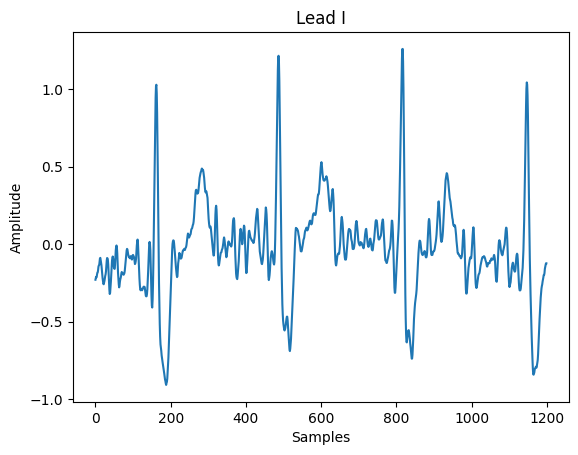

In [60]:
print(f"Leads available: {record.sig_name}")
plot_signal_lead(record=record, lead_name="I")

#### **Code-15% Dataset**

len chagas_label: 343424
exam_id: 418484
idx: [274426, 304020]
Keys available: ['exam_id', 'tracings']
(20001, 4096, 12)
exams_part7: [2867298  416736 1160836 ...  605304 1342756       0]
True
Index found: [2859]
Index found: 2859
Associated tracings: [[ -0.75458163  -0.9984868   -0.24390517 ... -15.968167    -0.20579499
   -1.7073362 ]
 [ -0.7416983   -0.98736054  -0.24566223 ... -15.993779    -0.19445887
   -1.6761489 ]
 [ -0.73513156  -0.9706356   -0.23550403 ... -15.936635    -0.1854795
   -1.6530582 ]
 ...
 [ -0.8768928   -1.2726284   -0.3957356  ...   0.9966566   -0.98401004
   -0.87747765]
 [ -0.8741664   -1.2706177   -0.39645132 ...   0.9962846   -0.9811447
   -0.87365764]
 [ -0.8770633   -1.2726268   -0.39556345 ...   0.9865607   -0.98260546
   -0.8778711 ]]
(4096, 12)


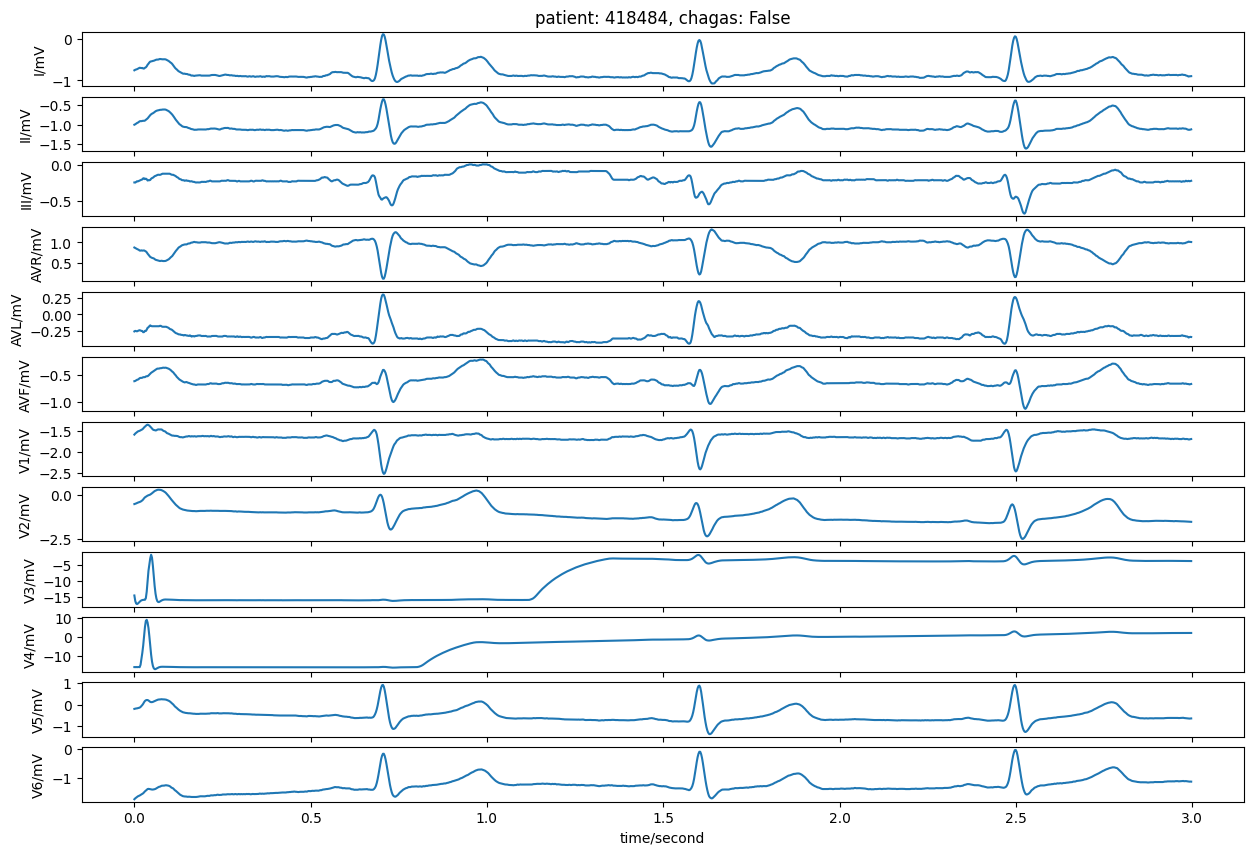

In [65]:
# Path file Code15% dataset and labels
hdf5_file = "datasets/code15/exams_part7.hdf5"
hdf5_labels = "datasets/code15/code15_chagas_labels.csv"

# Temporary name for WFDB file
temp_dir = tempfile.mkdtemp()
record_name = "test_record_code15"

# Signal parameters
sampling_frequency = 400  # In Hz
lead_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
units = "mV"
gain = 1000
num_bits = 16

df_labels = pd.read_csv(hdf5_labels)
exam_id = df_labels.iloc[0, 0]
patient_id = df_labels.iloc[0, 1] 
chagas = df_labels.iloc[0, 2] 
print(f"len chagas_label: {len(df_labels)}")

print(f"exam_id: {exam_id}")
df_data = pd.read_csv("datasets/code15/exams.csv")
idx = df_data.index[df_data['patient_id'] == patient_id].tolist()
print(f"idx: {idx}")

# Reads the first signal from the HDF5 file
with h5py.File(hdf5_file, "r") as f:
    print("Keys available:", list(f.keys()))
    print(f['tracings'].shape)
    data_test = f['exam_id'][:]
    print(f"exams_part7: {data_test}")
    print(f"{np.any(f['exam_id'][:] == exam_id)}")
    indices = np.where(f["exam_id"][:] == exam_id)[0]  # Find the location of the ID
    print(f"Index found: {indices}")
    if len(indices) > 0:
        idx = indices[0]  # Let's take the first match
        print(f"Index found: {idx}")
        print(f"Associated tracings: {f['tracings'][idx]}")
    else:
        print("ID not found in dataset!")
    physical_signals = np.squeeze(np.array(f['tracings'][idx], dtype=np.float32))  # First patient
    print(physical_signals.shape)
    num_samples, num_leads = physical_signals.shape
    assert num_leads == 12

# Convert signal to digital format for WFDB
digital_signals = np.round(physical_signals * gain).astype(np.int16)
digital_signals = np.clip(digital_signals, -2**(num_bits-1)+1, 2**(num_bits-1)-1)

# Save in WFDB format
wfdb.wrsamp(
    record_name=record_name,
    fs=400,  # Sampling rate
    units=['mV'] * 12,  # Unit of measurement for each derivation
    sig_name=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'],  # Nomi delle derivazioni
    d_signal=digital_signals,  # Digital signal
    fmt=['16'] * 12,  # 16-bit format for each derivation
    adc_gain=[1000] * 12,  # Gain for each derivation
    baseline=[0] * 12  # Baseline for each derivation
)

# Plot the signal using wfdb.plot_wfdb()
record = wfdb.rdrecord(f"test_record_code15", sampto=1200)
wfdb.plot_wfdb(record, figsize=(15, 10), title=f"patient: {exam_id}, chagas: {chagas}")
plt.show()

Leads available: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']


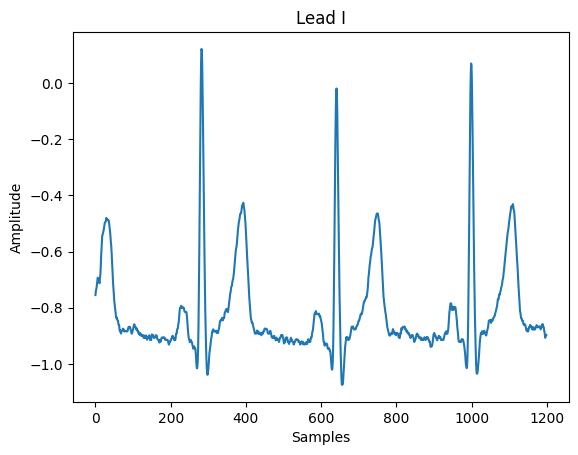

In [66]:
print(f"Leads available: {record.sig_name}")
plot_signal_lead(record=record, lead_name="I")

### **Preprocessing stage**

In [ ]:
# Function to apply bandpass filter
def bandpass_filter(signal_data: np.ndarray, low_cutoff: float = 0.5, high_cutoff: float = 150, fs: int = 400, order=3):
    # Butterworth band pass filter's parameters
    nyquist = 0.5 * fs  # Nyquist frequency
    low = low_cutoff / nyquist  # Normalized low cutoff frequency
    high = high_cutoff / nyquist  # Normalized high cutoff frequency
    
    # Create Butterworth band pass filter
    b, a = sp.signal.butter(order, [low, high], btype='band')
    
    # Apply filter to signal
    filtered_signal = sp.signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

#### **PTB-XL Preprocessing**

#### **SaMi-Trop Preprocessing**

#### **Code-15% Preprocessing**

### **Segmentation stage**

### **Classification stage**

### **Evaluation stage**

### **Conclusions**